In [1]:
from sklearn.datasets import fetch_mldata


In [2]:
mnist= fetch_mldata('MNIST original',data_home= './dataset/')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

['data'] :数组每一行表示一个样本，共有70000个样本，每个样本784个特征  
28*28=784，每张图片28*28像素，像素值介于0~255  
['target'] :标签

In [3]:
x,y= mnist['data'],mnist['target']
x.shape


(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


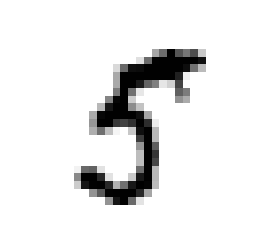

5.0

In [6]:
some_digit= x[36001]
some_digit_image= some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap= matplotlib.cm.binary,interpolation="nearest")
plt.axis("off")
plt.show()
y[36001]

In [7]:
x_train,x_test,y_train,y_test= x[:60000],x[60000:],y[:60000],y[60000:]

### 打乱 分割 数据集
因为原数据集按照数字顺序排列的，需要打乱顺序  
**生成随机索引序列**

In [8]:
import numpy as np


In [9]:
shuffle_index= np.random.permutation(60000)
x_train,y_train= x_train[shuffle_index],y_train[shuffle_index] 

### 训练二分类器

识别 ‘5’分类器

In [10]:
y_train5= (y_train == 5)
y_test5= (y_test == 5)
y_train5


array([False, False, False, ...,  True, False, False], dtype=bool)

In [11]:
y_train

array([ 1.,  4.,  8., ...,  5.,  8.,  4.])

In [12]:
from sklearn.linear_model import SGDClassifier
sgd_clf= SGDClassifier(random_state=42)
sgd_clf.fit(x_train,y_train5)

C:\Users\23818\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

这都能猜错！

### 性能评估

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import  clone

In [15]:
skfolds= StratifiedKFold(n_splits=3,random_state=42)
for train_index,test_index in skfolds.split(x_train,y_train5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = (y_train5[train_index])
    x_test_fold = x_train[test_index]
    y_test_fold = (y_train5[test_index])
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9299
0.93135
0.9652


交叉验证，cv=4 —把训练集分为4折

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
cross_val_score(sgd_clf, x_train, y_train5, cv=3, scoring="accuracy")

array([ 0.9299 ,  0.93135,  0.9652 ])

### 混淆矩阵

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [19]:
y_train_pred = cross_val_predict(sgd_clf,x_train,y_train5,cv=3)


cross_val_predict()也使用 K 折交叉验证。它不是返回一个评估分数，而是返回基于每一个测试折做出的一个预测值。

In [20]:
confusion_matrix(y_train5,y_train_pred)

array([[51900,  2679],
       [  792,  4629]], dtype=int64)

In [21]:
from sklearn.metrics import precision_score,recall_score

In [22]:
precision_score(y_train5,y_train_pred)
# 教程里写错了，不是 y_pred

0.6334154351395731

In [23]:
recall_score(y_train5,y_train_pred)

0.85390149418926398

In [24]:
from sklearn.metrics import f1_score


In [25]:
f1_score(y_train5,y_train_pred)

0.72731557860004714

#### 折中 P,R

In [26]:
y_scores= cross_val_predict(sgd_clf,x_train,y_train5,cv=3,method="decision_function")


In [27]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train5,y_scores[:,1]) #


In [28]:
y_scores

array([[      0.        , -279566.66325932],
       [      0.        , -414622.31030234],
       [      0.        , -411252.7412995 ],
       ..., 
       [      0.        ,  124387.91247064],
       [      0.        , -761031.91548869],
       [      0.        , -593163.41863049]])

y_scores 有两列，第一列不知道什么意思，，，，，第二列才是决策分数。y_scores[:,1]

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

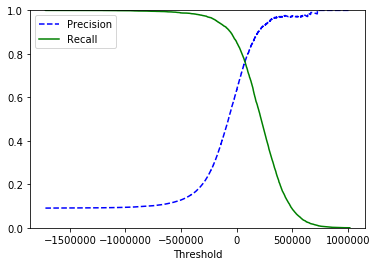

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [31]:
from sklearn.metrics import roc_curve

In [32]:
fpr,tpr,thresholds= roc_curve(y_train5,y_scores[:,1])

### label  不是lable

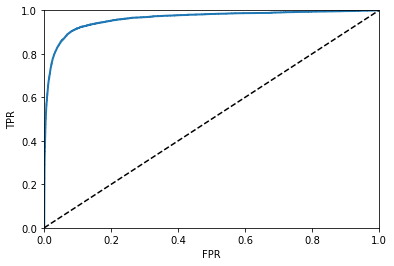

In [33]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,labeL=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
plot_roc_curve(fpr,tpr)

plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train5,y_scores[:,1])

0.96192721817962301

RandomForestClassifier不提供decision_function()方法。它提供了predict_proba()方法。predict_proba()方法返回一个数组，数组的每一行代表一个样例，每一列代表一个类。数组当中的值的意思是：给定一个样例属于给定类的概率。  
对于“数字5”分类器，y_pro_fore有两列，分别表示“否”“是”两类的概率。。。。。**如和确定第二列是“是5”的类**

In [35]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)

y_pro_fore=cross_val_predict(forest_clf,x_train,y_train5,cv=3,method="predict_proba")

但是要画 ROC 曲线，你需要的是样例的**得分分数**，而不是概率。一个简单的解决方法是使用正例的概率当作样例的分数。

In [36]:
y_scores_forest=y_pro_fore[:,1]
fpr_f,tpr_f,thre_f=roc_curve(y_train5,y_scores_forest)

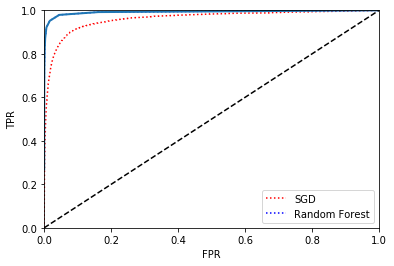

In [37]:
#plot_roc_curve(fpr,tpr,"SGD")直接调用自己写的函数，无法添加标注
plt.plot(fpr,tpr,"r:",label="SGD")#调用库函数，可以添加标注，但是坐标轴和函数规格也是默认的线段，不美观
plt.plot(fpr_f,tpr_f,"b:",label="Random Forest")
plot_roc_curve(fpr_f,tpr_f,"Random Froest")#库函数画一遍，自定义函数再画一遍，能出现标注而且图像有规格
plt.legend(loc="lower right") #buttom right 是不对的
plt.show()


plt像是创建一个画布，  
画完所有对象(调整，添加，修改)之后  
plt.show()显示最终的画布效果

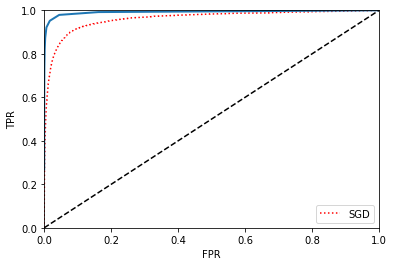

In [38]:
plt.plot(fpr,tpr,"r:",label="SGD")#调用库函数
#plt.plot(fpr_f,tpr_f,"b:",label="Random Forest")
plot_roc_curve(fpr_f,tpr_f,"Random Froest")
plt.legend(loc="lower right") #buttom right 是不对的
plt.show()

### 多分类

Scikit-Learn 可以探测出你想使用一个二分类器去完成多分类的任务，它会自动地执行 OvA（除了 SVM 分类器，它使用 OvO）

In [39]:
sgd_clf.fit(x_train,y_train)
sgd_clf.predict([some_digit])

array([ 5.])

In [40]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

一个分类器被训练好了之后，它会保存目标类别列表到它的属性classes_ 中去，按照值排序。在本例子当中，在classes_ 数组当中的每个类的索引方便地匹配了类本身，比如，索引为 5 的类恰好是类别 5 本身。但通常不会这么幸运。

想**强制 Scikit-Learn 使用 OvO 策略或者 OvA 策略**，你可以使用OneVsOneClassifier类或者OneVsRestClassifier类。创建一个样例，**传递一个二分类器**给它的构造函数。

In [41]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf= OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train,y_train)
ovo_clf.predict([some_digit])

C:\Users\23818\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 5.])

In [42]:
len(ovo_clf.estimators_)#分类器个数

45

随机森林分类器能够直接将一个样例分到多个类别，Scikit-Learn 没有必要去运行 OvO 或者 OvA  
predict_proba()，得到样例对应的类别的概率值的列表

In [43]:
forest_clf.fit(x_train,y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [44]:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0.1,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]])

使用交叉验证，评估多分类器

In [45]:
cross_val_score(sgd_clf,x_train,y_train,cv=3,scoring="accuracy")

array([ 0.85392921,  0.88164408,  0.85327799])

简单将输入正则化

In [46]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scaler=scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf,x_train_scaler,y_train,cv=3,scoring="accuracy")

array([ 0.90841832,  0.90869543,  0.91028654])

### 误差分析  
选择最适合的模型  
网格搜索GridSearchCV()调参

In [49]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaler, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

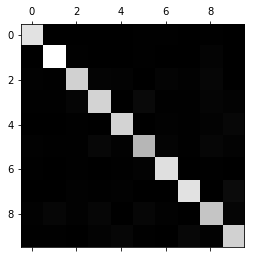

In [50]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

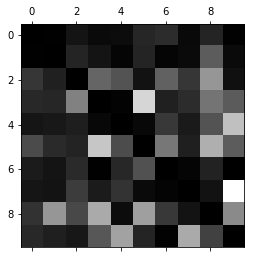

In [51]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)#对角线填充为0 ，纯黑，观察其他被分类错的区域
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

**记住：行代表实际类别，列代表预测的类别**  
越亮（白色）的格子数值越大，8,9列比较亮，许多图片被误分成数字 8 或者数字 9  
第 8、9 行也相当亮，数字 8、数字 9 经常被误以为是其他数字。  
第一行整体较暗，说明大部分“1”分类正确，少部分分到“5,6,8”  
误差图不是严格对称的(大体看起来有对称性)。举例子，比起将数字 9 误分类为数字 7 的数量，有更多的数字 7 被误分类为数字 9。  
  
  

分析混淆矩阵通常可以给你提供深刻的见解去改善你的分类器。回顾这幅图，看样子你应该努力改善分类器在数字 8 和数字 9 上的表现，举例子，你可以尝试去收集更多的数据，或者你可以构造新的、有助于分类器的特征。  
例子，写一个算法去数闭合的环（比如，数字 8 有两个环，数字 6 有一个， 5 没有）。又或者你可以预处理图片（比如，使用 Scikit-Learn，Pillow， OpenCV）去构造一个模式，比如闭合的环。